conda install pytorch torchvision torchaucio cudatoolkit=11.4 -c pytorch

# HuggingFace Custom PJT

In [1]:
import tensorflow
import numpy
import transformers
import datasets

print(tensorflow.__version__)
print(numpy.__version__)
print(transformers.__version__)
print(datasets.__version__)

2.6.0
1.21.4
4.11.3
1.14.0


In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2021 NVIDIA Corporation
Built on Wed_Jun__2_19:15:15_PDT_2021
Cuda compilation tools, release 11.4, V11.4.48
Build cuda_11.4.r11.4/compiler.30033411_0


In [3]:
import torch
torch.__version__

'1.9.1+cu111'

In [4]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

In [5]:
print(os.environ.get('CUDA_LAUNCH_BLOCKING'))

1


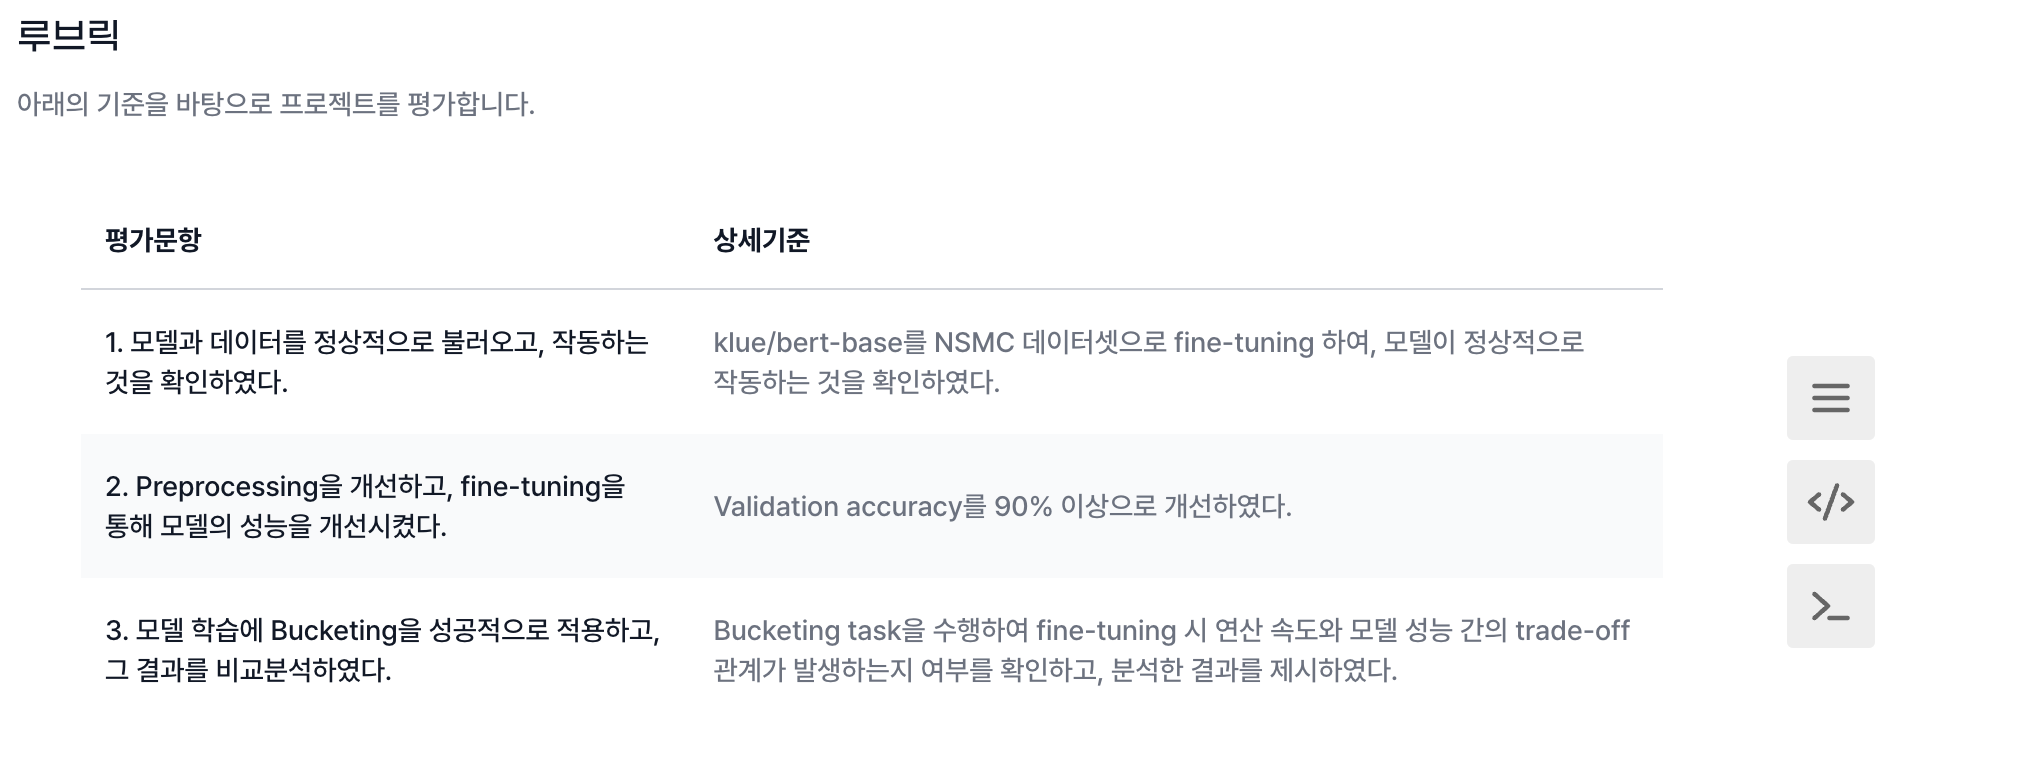

## STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성
- 데이터셋은 깃허브에서 다운받거나, Huggingface datasets에서 가져올 수 있습니다. 앞에서 배운 방법들을 활용해봅시다!

In [6]:
import datasets
from datasets import load_dataset

huggingface_NSMC_dataset = load_dataset('nsmc')
print(huggingface_NSMC_dataset)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [7]:
train = huggingface_NSMC_dataset['train']
cols = train.column_names
cols

['id', 'document', 'label']

In [8]:
test = huggingface_NSMC_dataset['test']
cols = test.column_names
cols

['id', 'document', 'label']

In [9]:
for i in range(10):
    for col in cols:
        print(col, ":", test[col][i])
    print('\n')

id : 6270596
document : 굳 ㅋ
label : 1


id : 9274899
document : GDNTOPCLASSINTHECLUB
label : 0


id : 8544678
document : 뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아
label : 0


id : 6825595
document : 지루하지는 않은데 완전 막장임... 돈주고 보기에는....
label : 0


id : 6723715
document : 3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??
label : 0


id : 7898805
document : 음악이 주가 된, 최고의 음악영화
label : 1


id : 6315043
document : 진정한 쓰레기
label : 0


id : 6097171
document : 마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다
label : 0


id : 8932678
document : 갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한cg남무 아 그립다 동사서독같은 영화가 이건 3류아류작이다
label : 0


id : 6242223
document : 이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..
label : 1




## STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [12]:
import transformers
from transformers import AutoModel, AutoTokenizer, AutoModelForSequenceClassification

huggingface_model = AutoModelForSequenceClassification.from_pretrained('klue/bert-base', num_labels = 2)
huggingface_tokenizer = AutoTokenizer.from_pretrained("klue/bert-base")

Some weights of the model checkpoint at klue/bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized

## STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기


In [13]:
# 토크나이징
# transform 함수, 이전에 만들었던 Tokenizer 활용하여 dataset 형태 확인하고 바꿀 대상 지정
def transform(data):
    return huggingface_tokenizer(
        data['document'],
        truncation = True, # 특정 문장이 길면 모델 다루기 힘들어질 수 있어서 짧게 자르기
        padding = 'max_length',
        return_token_type_ids = True, #문장이 한개이상일 때 나뉘는
        )

In [14]:
# 데이터셋 한번에 토크나이징 Map
hf_dataset = huggingface_NSMC_dataset.map(transform, batched=True) # map을 사용해 토크나이징 진행 -> batch 적용

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-402051d337e50659.arrow


  0%|          | 0/50 [00:00<?, ?ba/s]

In [15]:
hf_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 50000
    })
})

In [16]:
# 1. Dateset split 적용
spilt_dataset = hf_dataset['train'].train_test_split(test_size=0.2)
spilt_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 30000
    })
})

In [17]:
# 2. spilt한 데이터 저장
train_dataset, validation_dataset = spilt_dataset['train'], spilt_dataset['test']
train_dataset, validation_dataset

(Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 120000
 }),
 Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 30000
 }))

In [31]:
# 3. train & validation & test split 및 1/10 샘플링
hf_train_dataset = train_dataset.shuffle(seed=42).select(range(6000))
hf_val_dataset = validation_dataset.shuffle(seed=42).select(range(1500))
hf_test_dataset = hf_dataset['test'].shuffle(seed=42).select(range(2500))

hf_train_dataset, hf_val_dataset, hf_test_dataset

Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-7e830a6a0cd52152.arrow
Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-9ca638a55a5bffd3.arrow
Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-f2846066a4f77957.arrow


(Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 6000
 }),
 Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 1500
 }),
 Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 2500
 }))

In [19]:
print(set(hf_train_dataset['label']))
print(set(hf_test_dataset['label']))
print(set(hf_val_dataset['label']))

{0, 1}
{0, 1}
{0, 1}


In [32]:
# Trainer를 사용하기 위해서는 TrainingArguments를 통해 학습 관련 설정을 미리 지정
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/output'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    gradient_accumulation_steps =2
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [23]:
from datasets import load_metric
from sklearn.metrics import accuracy_score, f1_score

# 정확도(Accuracy)와 F1 점수(F1 Score)를 계산하는 compute_metrics 함수
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(labels, preds)
    f1 = f1_score(labels, preds, average='weighted')
    return {
        'accuracy': acc,
        'f1': f1,
    }

In [36]:
from transformers import DataCollatorForLanguageModeling
data_collator = DataCollatorForLanguageModeling(tokenizer=huggingface_tokenizer, mlm_probability=0.15)

In [35]:
rm -rf ~/.nv/ComputeCache

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [38]:
trainer = Trainer(
    model=huggingface_model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
#     data_collator=data_collator,
)

trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 6000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 1125


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.293200,0.888000,0.887851
2,0.301100,0.337213,0.882667,0.882653
3,0.149800,0.476903,0.878000,0.877970


The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/output/checkpoint-500
Configuration saved in /aiffel/aiffel/output/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/output/checkpoint-500/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/output/checkpoint-1000
Configuration saved in /aiffel/aiffel/output/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/output/checkpoint-1000/pytorch_model.bin
The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassif

TrainOutput(global_step=1125, training_loss=0.21248609161376952, metrics={'train_runtime': 1994.6208, 'train_samples_per_second': 9.024, 'train_steps_per_second': 0.564, 'total_flos': 4735998996480000.0, 'train_loss': 0.21248609161376952, 'epoch': 3.0})

In [39]:
# test
trainer.evaluate(hf_test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 2500
  Batch size = 8


{'eval_loss': 0.543034553527832,
 'eval_accuracy': 0.8576,
 'eval_f1': 0.8575999999999998,
 'eval_runtime': 100.1902,
 'eval_samples_per_second': 24.953,
 'eval_steps_per_second': 3.124,
 'epoch': 3.0}

## STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기
- 데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.


In [60]:
import re

def preprocess_text(text):
    if isinstance(text, str): 
        # 텍스트 클리닝
        text = re.sub(r'[^가-힣ㄱ-ㅎㅏ-ㅣ0-9\s]', '', text)  # 한글, 숫자, 공백을 제외한 모든 문자 제거
        text = re.sub(r'\s+', ' ', text)  # 여러 개의 공백을 하나의 공백으로 대체

        # 토큰화
        tokens = text.split()  # 공백을 기준으로 토큰화 (간단한 예시)

        # 불용어 제거
        stopwords = [
        '이', '있', '하', '것', '들', '그', '되', '수', '보', '않', '없', '나', '주', 
        '아니', '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', 
        '위하', '때문', '또', '더', '많', '그리고', '좋', '크', '따르', 
        '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하', '그러', '속', '하나', '집', 
        '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '경우', '명', '생각', '시간', 
        '다시', '앞', '보이', '번', '나', '다른', '여자', '개', '전', 
        '사실', '이렇', '점', '싶', '말하', '정도', '좀', '원', '잘', '통하', 
        '다', '지나', '가장', '말', '알', '서', '쪽', '참', '실제', '아', '다음', '본', '자', 
        '이제', '뭐', '더욱', '아무', '바', '이', '보다', '받', '못하', '일', 
        '그만', '이번', '각', '어떻', '여기', '저', '속', '정말', '인', '그', '이거', '어느', 
        '물', '적', '알', '그러나', '어디', '여', '가지', '종류', '싶', '주', '요', '몇', '거의', 
        '마다', '더욱이', '많이', '쉽', '크', '다소', '다수', '더러', '종종', '가끔', '오히려', '빠르', 
        '힘들', '어렵', '아래', '이상', '간', '중', '중요', '여부', '사실', '한편', '제', '모든', 
        '너', '네', '당신', '우리', '그들', '너희', '누구', '각자', '어떤', '이런', '저런', '같은'
    ]

        tokens = [token for token in tokens if token not in stopwords]

    
        return ' '.join(tokens)
    else:
        return '' 

# 데이터 전처리 적용
def preprocess_data(data):
    preprocessed_data = [preprocess_text(text) for text in data]
    return preprocessed_data

In [61]:
# 토크나이져 과정에서 패딩 최대길이 설정
def transform(data):
    preprocessed_text = preprocess_text(data['document'])

    return huggingface_tokenizer(
        preprocessed_text,
        truncation = True,
        padding = True,
        max_length=40,
        return_token_type_ids = True,
        )

In [62]:
# 데이터셋 한번에 토크나이징 Map
hf_dataset = huggingface_NSMC_dataset.map(transform, batched=True) # map을 사용해 토크나이징 진행 -> batch 적용

  0%|          | 0/150 [00:00<?, ?ba/s]

  0%|          | 0/50 [00:00<?, ?ba/s]

In [63]:
# 1. Dateset split 적용
spilt_dataset = hf_dataset['train'].train_test_split(test_size=0.2)
spilt_dataset

DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
        num_rows: 30000
    })
})

In [64]:
# 2. spilt한 데이터 저장
train_dataset, validation_dataset = spilt_dataset['train'], spilt_dataset['test']
train_dataset, validation_dataset

(Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 120000
 }),
 Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 30000
 }))

In [65]:
# 3. train & validation & test split 및 1/10 샘플링
hf_train_dataset = train_dataset.shuffle(seed=42).select(range(12000))
hf_val_dataset = validation_dataset.shuffle(seed=42).select(range(3000))
hf_test_dataset = hf_dataset['test'].shuffle(seed=42).select(range(5000))

hf_train_dataset, hf_val_dataset, hf_test_dataset

(Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 12000
 }),
 Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 3000
 }),
 Dataset({
     features: ['attention_mask', 'document', 'id', 'input_ids', 'label', 'token_type_ids'],
     num_rows: 5000
 }))

In [66]:
# Trainer를 사용하기 위해서는 TrainingArguments를 통해 학습 관련 설정을 미리 지정
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/output'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 8,   # 각 device 당 batch size
    per_device_eval_batch_size = 8,    # evaluation 시에 batch size
    num_train_epochs = 3,                     # train 시킬 총 epochs
    weight_decay = 0.05,                        # weight decay
    gradient_accumulation_steps =2
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
trainer = Trainer(
    model=huggingface_model_2,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator=data_collator,  # 데이터 컬레이터 설정
    tokenizer=tokenizer
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 12000
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 2
  Total optimization steps = 2250


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.235000,0.420334,0.859333,0.859212
2,0.151400,0.562821,0.860667,0.860604


Saving model checkpoint to /aiffel/aiffel/output/checkpoint-500
Configuration saved in /aiffel/aiffel/output/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/output/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/output/checkpoint-500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/output/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 3000
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/output/checkpoint-1000
Configuration saved in /aiffel/aiffel/output/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/output/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/output/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/output/checkpoint-10

## STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교
- 아래 링크를 바탕으로 bucketing과 dynamic padding이 무엇인지 알아보고, 이들을 적용하여 model을 학습시킵니다.

    - [Data Collator](https://huggingface.co/docs/transformers/v4.30.0/en/main_classes/data_collator)
    - [Trainer.TrainingArguments 의 ```group_by_length```](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments)

- STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보고, 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.

In [40]:
from transformers import DataCollatorWithPadding
from transformers import BertTokenizer

huggingface_model_2 = AutoModelForSequenceClassification.from_pretrained('klue/roberta-small', num_labels = 2)
tokenizer = BertTokenizer.from_pretrained("klue/bert-base")

# 데이터를 토큰화하고 패딩을 추가하는 DataCollatorWithPadding 인스턴스 생성
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_arguments = TrainingArguments(
    output_dir,                            # output이 저장될 경로
    evaluation_strategy="epoch",           # evaluation하는 빈도
    learning_rate = 2e-5,                  # learning_rate
    per_device_train_batch_size = 8,       # 각 device 당 batch size
    per_device_eval_batch_size = 8,        # evaluation 시에 batch size
    num_train_epochs = 5,                  # train 시킬 총 epochs
    weight_decay = 0.01,                   # weight decay
    #lr_scheduler_type="polynomial",
    group_by_length=True                   # https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments.ddp_bucket_cap_mb
)

trainer = Trainer(
    model=huggingface_model_2,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset=hf_train_dataset,    # training dataset
    eval_dataset=hf_val_dataset,       # evaluation dataset
    compute_metrics=compute_metrics,
    data_collator=data_collator,  # 데이터 컬레이터 설정
    tokenizer=tokenizer
)
trainer.train()

https://huggingface.co/klue/roberta-small/resolve/main/config.json not found in cache or force_download set to True, downloading to /aiffel/.cache/huggingface/transformers/tmpf0umdidr


Downloading:   0%|          | 0.00/545 [00:00<?, ?B/s]

storing https://huggingface.co/klue/roberta-small/resolve/main/config.json in cache at /aiffel/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
creating metadata file for /aiffel/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
loading configuration file https://huggingface.co/klue/roberta-small/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/6aa0817a5b48e36ec821c3d9cb8267f2dda41a32b317311688f06c742b6b2a1d.7f009d6b27d54554dce063a5fc8273742e9a198f6f627aada4bc5ea2dbbc0313
Model config RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_id": 2,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_

Downloading:   0%|          | 0.00/260M [00:00<?, ?B/s]

storing https://huggingface.co/klue/roberta-small/resolve/main/pytorch_model.bin in cache at /aiffel/.cache/huggingface/transformers/fafa42c8bb6f4b1313506774e000bc35d156dce6eb02c75a5e4a37405e0bac4a.57e9f25d17aa6a6c07d65c9c33f5319ede6e71bccfe0f3910dddf6a7598919d9
creating metadata file for /aiffel/.cache/huggingface/transformers/fafa42c8bb6f4b1313506774e000bc35d156dce6eb02c75a5e4a37405e0bac4a.57e9f25d17aa6a6c07d65c9c33f5319ede6e71bccfe0f3910dddf6a7598919d9
loading weights file https://huggingface.co/klue/roberta-small/resolve/main/pytorch_model.bin from cache at /aiffel/.cache/huggingface/transformers/fafa42c8bb6f4b1313506774e000bc35d156dce6eb02c75a5e4a37405e0bac4a.57e9f25d17aa6a6c07d65c9c33f5319ede6e71bccfe0f3910dddf6a7598919d9
Some weights of the model checkpoint at klue/roberta-small were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.decoder.w

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.463800,0.346997,0.873333,0.873300
2,0.334200,0.528907,0.873333,0.873310
3,0.223300,0.490718,0.873333,0.873325
4,0.142400,0.654382,0.873333,0.873210
5,0.086000,0.699780,0.875333,0.875227


Saving model checkpoint to /aiffel/aiffel/output/checkpoint-500
Configuration saved in /aiffel/aiffel/output/checkpoint-500/config.json
Model weights saved in /aiffel/aiffel/output/checkpoint-500/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/output/checkpoint-500/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/output/checkpoint-500/special_tokens_map.json
The following columns in the evaluation set  don't have a corresponding argument in `RobertaForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 1500
  Batch size = 8
Saving model checkpoint to /aiffel/aiffel/output/checkpoint-1000
Configuration saved in /aiffel/aiffel/output/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/output/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in /aiffel/aiffel/output/checkpoint-1000/tokenizer_config.json
Special tokens file saved in /aiffel/aiffel/output/checkpoint-10

TrainOutput(global_step=3750, training_loss=0.2510451863606771, metrics={'train_runtime': 1766.592, 'train_samples_per_second': 16.982, 'train_steps_per_second': 2.123, 'total_flos': 3974021959680000.0, 'train_loss': 0.2510451863606771, 'epoch': 5.0})

### 프로젝트 회고: NSMC 감성 분석을 위한 모델 파인튜닝과 최적화의 딜레마

#### **프로젝트 개요**

이번 프로젝트의 목표는 네이버 영화 리뷰 데이터셋(NSMC)을 사용하여 감성 분석 모델을 구축하고, 해당 모델의 성능을 최적화하는 것이었습니다. 이 과정에서 불용어 제거, 텍스트 전처리, 모델 파인튜닝 등 전처리 및 최적화 기법을 적용해 보았습니다.

#### **과정**

1. **데이터 전처리**: 한글, 숫자, 공백을 제외한 모든 문자 제거와 공백 정규화를 통해 데이터를 클리닝했습니다. 추가로, 영화 리뷰 데이터의 특성을 고려하여 다양한 불용어를 제거하는 작업을 진행했습니다.

2. **모델 선택 및 파인튜닝**: Hugging Face의 Transformers 라이브러리를 활용하여, 사전 훈련된 모델을 기반으로 파인튜닝을 진행했습니다. 이 과정에서 학습률, 배치 크기, 에폭 수 등의 하이퍼파라미터를 조정하며 모델의 성능을 향상시키기 위한 시도를 했습니다.

3. **성능 평가**: 파인튜닝을 마친 모델을 테스트 데이터셋에 적용하여, 모델의 성능을 평가했습니다. 이 때, 기본적인 전처리만을 적용한 모델부터 시작하여 점차 복잡한 최적화 기법을 추가해가며 모델의 성능 변화를 관찰했습니다.

#### **결과 및 발견**

프로젝트 진행 과정에서 가장 기본적인 전처리만을 적용한 모델이 가장 높은 성능을 보였습니다. 복잡한 전처리 과정과 모델 파인튜닝이 오히려 모델의 성능을 저하시키는 결과를 가져왔습니다. 이는 감성 분석과 같은 자연어 처리 작업에서 전처리와 모델 최적화가 항상 성능 향상을 보장하지 않을 수 있음을 시사합니다.

#### **회고**

- **데이터의 이해**: 데이터의 특성을 정확히 이해하지 못하고 너무 많은 불용어를 제거하거나, 과도한 전처리를 적용한 것이 문제였을 수 있습니다. 특히 감성 분석과 같은 경우, 감정을 표현하는 데 중요한 단어들까지 불용어로 간주하여 제거했을 가능성이 있습니다.

- **모델 최적화의 한계**: 복잡한 모델 최적화 과정이 항상 긍정적인 결과를 가져오는 것은 아닙니다. 경우에 따라서는 모델의 복잡성을 증가시켜 오히려 과적합을 유발하거나, 특정 데이터셋의 특성을 제대로 학습하지 못할 수 있습니다.

- **실험의 중요성**: 다양한 전처리 방법과 하이퍼파라미터 설정을 실험해보는 것의 중요성을 재확인했습니다. 각 설정과 조정이 모델의 성능에 어떤 영향을 미치는지 체계적으로 기록하고 분석함으로써, 예상치 못한 결과에 대해 더 깊이 이해할 수 있었습니다.

#### **향후 개선점**

- **데이터와 모델의 관계 이해 강화**: 모델의 성능을 최적화하기 위해서는 단순히 다양한 기법을 시도하는 것뿐만 아니라, 데이터의 특성과 모델이 어떻게 이를 학습하는지에 대한 깊은 이해가 필요합니다. 특히 감성 분석과 같은 미묘하고 복잡한 태스크에서는 데이터에 내재된 감성의 뉘앙스를 정확히 포착할 수 있는 전처리 방법과 모델 구조에 대한 고민이 필요합니다.

- **간결함의 미덕**: 때로는 간단한 모델과 전처리 방법이 더 효과적일 수 있습니다. 복잡한 기법을 도입하기 전에, 기본적인 모델 구조와 가장 필수적인 데이터 전처리 과정에서부터 시작하여 점진적으로 개선해 나가는 접근 방식이 필요합니다.

- **체계적인 실험 설계와 분석**: 다양한 설정과 조정을 실험할 때, 각 실험의 설정을 체계적으로 기록하고 그 결과를 정리하는 것이 중요합니다. 이를 통해 어떤 접근 방법이 효과적이었는지, 또는 예상과 다른 결과를 초래한 원인은 무엇인지 분석할 수 있습니다.

#### **결론**

이번 프로젝트를 통해 모델 파인튜닝과 데이터 전처리가 모델 성능에 미치는 영향에 대해 깊이 탐구할 기회를 가졌습니다. 특히, 기본적인 접근 방법이 때로는 가장 효과적일 수 있다는 중요한 교훈을 얻었습니다. 자연어 처리 분야에서는 데이터의 특성과 모델의 작동 방식을 정확히 이해하는 것이 성공적인 모델 구축의 핵심임을 다시 한번 확인할 수 있었습니다. 앞으로 이러한 경험을 바탕으로 더욱 세심하고 체계적인 접근 방식을 개발해 나가고자 합니다.

In [ ]:
!nvidia-smi